In [6]:
from functions import *

# Load optimized RA schedule and data

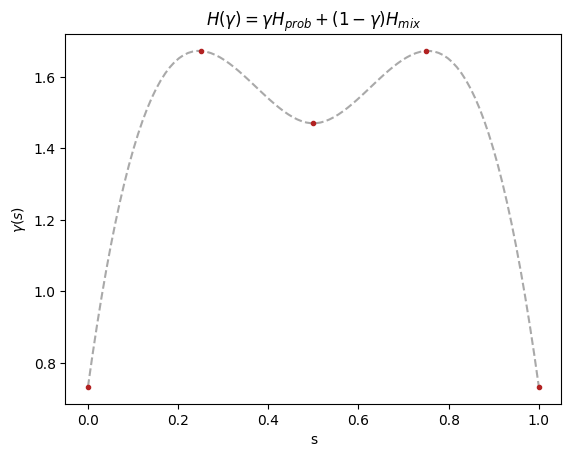

In [7]:
data = load_from_json('n6_cubic_cobyla_lbfgsb.json')

n = data['n']
t_max = data['t_max']
interpolator_kind = data['interpolator_kind']

schedule = data['schedule_finetuned']
schedule_interpolator = get_schedule_interpolator(schedule, kind=interpolator_kind) # get an interpolating function for the continuos schedule

plot_schedule(schedule, schedule_interpolator)

# Temperature sweep

In [20]:
num_random_models = 1
num_temperatures = 20

T_range = np.geomspace(0.001, 1000, num_temperatures)

def f(T):
    '''
    Calculate spectral gaps for quantum proposals.
    f(T) is defined to parallelize the temperature-loop.
    '''   
    delta_random_arr = np.zeros((num_random_models))
    delta_local_arr = np.zeros((num_random_models))
    delta_quantum_arr = np.zeros((num_random_models))
    delta_quantum_fixed_arr = np.zeros((num_random_models))
    delta_ra_arr = np.zeros((num_random_models))

    for i in range(num_random_models):
        m = RandomIsingModel(n, seed=i) # set the seed for reproducibility

        proposal_mat_random = get_proposal_mat_random(m)
        P_random = get_transition_matrix(m, T, proposal_mat_random)
        delta_random = get_delta(P_random)
        delta_random_arr[i] = delta_random

        proposal_mat_local = get_proposal_mat_local(m)
        P_local = get_transition_matrix(m, T, proposal_mat_local)
        delta_local = get_delta(P_local)
        delta_local_arr[i] = delta_local
    
        proposal_mat_quantum = get_proposal_mat_quantum_avg(m)
        P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
        delta_quantum = get_delta(P_quantum)
        delta_quantum_arr[i] = delta_quantum

        proposal_mat_quantum_fixed = get_proposal_mat_quantum(m, gamma=0.5, t=10)
        P_quantum_fixed = get_transition_matrix(m, T, proposal_mat_quantum_fixed)
        delta_quantum_fixed = get_delta(P_quantum_fixed)
        delta_quantum_fixed_arr[i] = delta_quantum_fixed

        proposal_mat_ra = get_proposal_mat_ra(m, schedule_interpolator, t_max, assert_symmetry=False)
        P_ra = get_transition_matrix(m, T, proposal_mat_ra)
        delta_ra = get_delta(P_ra)
        delta_ra_arr[i] = delta_ra

    return delta_random_arr, delta_local_arr, delta_quantum_arr, delta_quantum_fixed_arr, delta_ra_arr

In [21]:
print('got here')

got here


In [22]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f)(T) for T in tqdm(T_range)))
sweep_data = sweep_data.swapaxes(0,1)

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


In [23]:
delta_random_arr = sweep_data[0]
delta_local_arr = sweep_data[1]
delta_quantum_arr = sweep_data[2]
delta_quantum_fixed_arr = sweep_data[3]
delta_ra_arr = sweep_data[4]

# Average and plot the results

In [24]:
# Take an average over random Ising instances
delta_random_arr_avg = np.mean(delta_random_arr, axis=1)
delta_random_arr_std = np.std(delta_random_arr, axis=1)

delta_local_arr_avg = np.mean(delta_local_arr, axis=1)
delta_local_arr_std = np.std(delta_local_arr, axis=1)

delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=1)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=1)

delta_quantum_fixed_arr_avg = np.mean(delta_quantum_fixed_arr, axis=1)
delta_quantum_fixed_arr_std = np.std(delta_quantum_fixed_arr, axis=1)

delta_ra_arr_avg = np.mean(delta_ra_arr, axis=1)
delta_ra_arr_std = np.std(delta_ra_arr, axis=1)

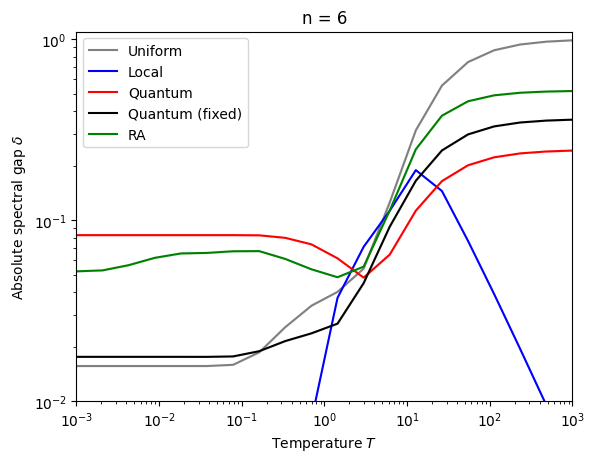

In [25]:
plt.plot(T_range, delta_random_arr_avg, '-', color='grey', label = 'Uniform')
plt.plot(T_range, delta_local_arr_avg, '-', color='blue', label = 'Local')
plt.plot(T_range, delta_quantum_arr_avg, '-', color='red', label = 'Quantum')
plt.plot(T_range, delta_quantum_fixed_arr_avg, '-', color='black', label = 'Quantum (fixed)')
plt.plot(T_range, delta_ra_arr_avg, '-', color='green', label = 'RA')

plt.fill_between(T_range, 
                 delta_random_arr_avg-delta_random_arr_std, 
                 delta_random_arr_avg+delta_random_arr_std, 
                 color='grey',
                 alpha=0.1)
plt.fill_between(T_range, 
                 delta_local_arr_avg-delta_local_arr_std, 
                 delta_local_arr_avg+delta_local_arr_std, 
                 color='blue',
                 alpha=0.1)
plt.fill_between(T_range, 
                 delta_quantum_arr_avg-delta_quantum_arr_std, 
                 delta_quantum_arr_avg+delta_quantum_arr_std, 
                 color='red',
                 alpha=0.1)
plt.fill_between(T_range, 
                 delta_quantum_fixed_arr_avg-delta_quantum_fixed_arr_std, 
                 delta_quantum_fixed_arr_avg+delta_quantum_fixed_arr_std, 
                 color='black',
                 alpha=0.1)
plt.fill_between(T_range, 
                 delta_ra_arr_avg-delta_ra_arr_std, 
                 delta_ra_arr_avg+delta_ra_arr_std, 
                 color='green',
                 alpha=0.1)

plt.title(f'n = {n}')
plt.xlabel('Temperature $T$')
plt.ylabel('Absolute spectral gap $\delta$')
plt.ylim(0.01, 1.1)
plt.xlim(0.001, 1000)
plt.yscale('log')
plt.xscale('log')
plt.legend()